# Simulation of Contrast Transfer Function

In [1]:
import numpy as np
import cv2 as cv
from numpy.fft import *
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

## Fourier Transfer Part

In [2]:
# 获取图像
def get_image(path): # invert_contrast = -1
  try:
      image = cv.imread(path, 0) # 转为灰度图处理
  except:
      return None
  vmin, vmax = np.percentile(image, (5, 95))
  image = (image - vmin)/(vmax - vmin)    # set to range [0, 1] => 图像归一化
  # detect if the image contrast should be inverted (i.e. to make background black)
  # edge_vals = np.mean([image[0, :].mean(), image[-1, :].mean(), image[:, 0].mean(), image[:, -1].mean()])
  # invert_contrast = edge_vals > 0.5
  return image

In [24]:
# 获取图像
img = get_image('bacteria1.jpg')
# 处理图像到指定尺寸
SIDE = 568
dim = (SIDE, SIDE)
resized_img = cv.resize(img, dim, interpolation = cv.INTER_AREA)
#进行傅立叶变换
fft2_image = np.fft.fft2(resized_img)
#将图像变换的原点移动到频域矩形的中心
shift2center = np.fft.fftshift(fft2_image)
disp_img = 20 * np.log(np.abs(shift2center))
# cv2_imshow(disp_img)

## CTF Part

* 已知:&emsp;图像的傅里叶变换 = 对象的傅里叶变换 × CTF, *i.e.*</br>
$$ \mathscr{F}\left\{Image\right\} = \mathscr{F}\left\{Object\right\}*CTF $$


所以, 我们给图像加上CTF噪声直接对傅里叶变换得到的频域图像乘上CTF.</br>
现在, 我们考虑CTF的形式: </br>

$$ CTF = sin(-\pi\Delta{z}\lambda{k}^2 + \frac{\pi{C_s}{\lambda}^3{k}^4}{2}) $$

此外, 还有极坐标下的形式:

$$ CTF = sin(\frac{-πzθ^2}{λ} + \frac{πC_sθ^4}{2λ})) $$


参数说明:

| param   | description           |   value   |
| ---- | -------------- | ---- |
| Δz   | 散焦           |0.277Å|
| λ    | 放射波波长     |1.97 pm(300keV)|
| k    | 空间频率       | θ=λk |
| Cs   | 物镜的球差系数 |2.7μm|
| θ |  透射电子波之间的散射角  |0~2π(or 0 ~ 360°)|

* [Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy#Scherzer_defocus)</br>

散焦通过球差和加速电压(通过波长)给出:

$$ \Delta{f_{Scherzer}} = -1.2\sqrt{C_s\lambda} $$

1.2定义了扩展的Scherzer散焦. 对于NCEM的CM300, 球差=0.6mm 加速电压=300keV (波长=1.97 pm), 可以得到ΔfScherzer=-41.25 nm.

In [53]:
class CTF:
  # 初始化参数
  def __init__(self, voltage=300.0, Cs=2.7, wavelength=0.0197, ampcontrast=7.0, defocus=0.277, dfdiff=0.0, dfang=0.0, phaseshift=0.0, bfactor=50.0, apix=1.0, imagesize=256, over_sample=1):
    self.voltage = voltage # 加速电压 默认300kV, 数值为300
    self.Cs = Cs  # 球差系数 默认 2.7埃 或 7μm
    self.ampcontrast = ampcontrast # 幅度对比度, 默认为7
    self.defocus = defocus # 散焦, 默认值0.277埃
    self.wavelength = wavelength # 波长, 1.97pm
    self.dfdiff = dfdiff # 散焦改变, 默认值0
    self.dfang = dfang # 散焦角度, 默认值0
    self.phaseshift = phaseshift # 相移, 默认值0
    self.bfactor = bfactor # B因子, 默认值50
    self.apix = apix # 单个像素大小, 默认值1
    self.imagesize = int(imagesize) # 图像尺寸
    self.over_sample = int(over_sample) # 过采样 默认值为1即正常采样
  # 获取波长, 通过加速电压给出
  def get_wavelength(self) -> float:
    return 12.2639 / np.sqrt(self.voltage * 1e3 + 0.97845 * self.voltage**2)  # 单位: 埃
    # return 12.2643247 / np.sqrt(energy * (1 + energy * 0.978466e-6)) * 1e-10
  # 获取散焦, 通过给定的球差系数和电子能量给出, 采用Scherzer defocus
  def get_defocus(self):
    return 1.2 * np.sqrt(self.Cs * self.wavelength) # 单位: mm
  # 计算二维CTF
  def ctf(self):
    s_nyquist = 1./(2 * self.apix) # nyquist采样
    ds = s_nyquist / (self.imagesize // 2 * self.over_sample) # nyquist采样 / (图像大小/2取下限) * 过采样
    sx = np.arange(-self.imagesize * self.over_sample // 2, self.imagesize * self.over_sample//2) * ds
    sy = np.arange(-self.imagesize * self.over_sample // 2, self.imagesize * self.over_sample//2) * ds
    sx, sy = np.meshgrid(sx, sy, indexing='ij') # 通过sx, sy构造网格
    theta = -np.arctan2(sy, sx) # 计算相位
    s2 = sx ** 2 + sy ** 2 # 空间频率的二次方
    s = np.sqrt(s2) # 空间频率
    s3 = s**3 # 空间频率的三次方
    del sx, sy # 释放掉sx, sy
    df = self.get_defocus() # 计算散焦
    # 计算二维的散焦
    defocus2d = df + self.dfdiff / 2 * np.cos(2 * (theta - self.dfang * np.pi/180.))
    # 计算相位偏移
    wl = self.get_wavelength()
    phaseshift = self.phaseshift * np.pi / 180.0 + np.arcsin(self.ampcontrast/100.)
    # 计算ctf函数的参数gamma
    gamma = 2 * np.pi * (-0.5 * defocus2d * 1e4 * wl * s2 + .25 * self.Cs * 1e7 * wl**3 * s2**2) - phaseshift
    # 模拟衰减
    env = np.ones_like(gamma) # 初始化信封函数: 按照gamma的格式再构造一个矩阵并初始化为1
    env *= np.exp(-self.bfactor * s2 / 4.0) # 根据b因子调用envelope函数
    ctf = np.sin(gamma) * env # 衰减
    del gamma, env, phaseshift, defocus2d, ds, s2, s3, theta # 释放掉使用过的变量
    return s, ctf

*ps: 运算的效率 > 变量自相乘的效率 > 调包的效率*

In [55]:
var = CTF() # 由于采用self, 必须实例化一个对象
var.__init__(imagesize=568) # 初始化CTF, 采用默认参数
spatial_freq, ctf = var.ctf() # 获取空间频率和ctf

## Image Processing Part

* 直接在傅里叶空间中逐点相乘

In [47]:
after_ctf = np.multiply(fft2_image, ctf)
result = np.fft.ifft2(after_ctf)

/usr/local/lib/python3.7/dist-packages/google/colab/patches/__init__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.clip(0, 255).astype('uint8')


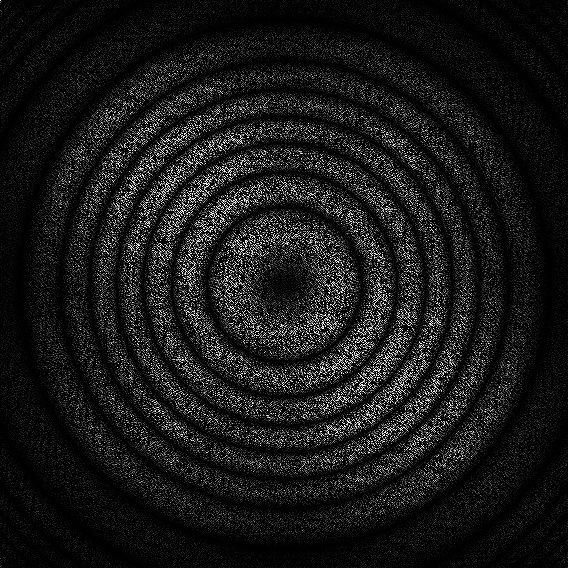

In [44]:
cv2_imshow(after_ctf*10)

/usr/local/lib/python3.7/dist-packages/google/colab/patches/__init__.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  a = a.clip(0, 255).astype('uint8')


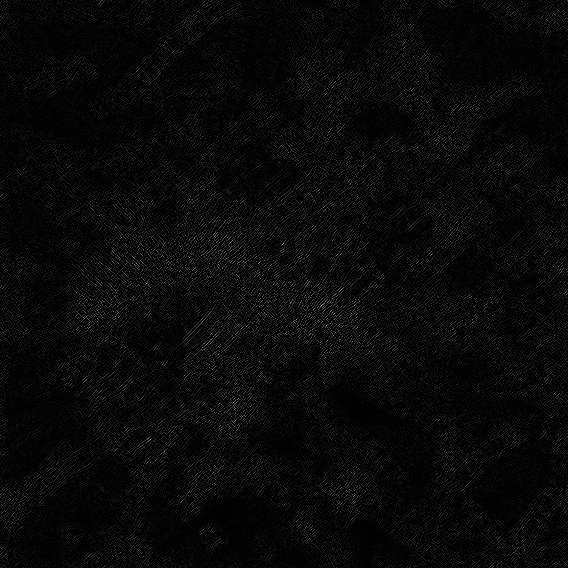

In [48]:
cv2_imshow(result*1e3)

## Drawing Part

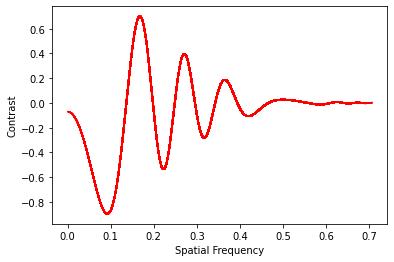

In [59]:
# 指定坐标标签
plt.xlabel("Spatial Frequency")
plt.ylabel("Contrast")
# 绘制
plt.plot(spatial_freq, ctf, "red"); # 加分号确保不显示[<matplotlib.lines.Line2D at ...]

## &emsp;

----

$$\mathcal{End}$$